## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [1]:
# can I do: output = !pip install ipympl?
# !pip install ipympl

In [2]:
# this shows ipympl is not in the JaxEnv backend
# !conda list ipympl

In [3]:
#!nvidia-smi

In [4]:
from platform import python_version
print(python_version())

3.9.13


In [1]:
%matplotlib inline
# %matplotlib ipympl
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import sis, epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel


import optax
tfd = tfp.distributions


from ipdb import set_trace

# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/Users/xiaoshenghuang/miniforge3/lib/python3.9/os.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/model.py


1

In [2]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)


# more readable form 
def extract_params(best_params):

    # mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    # shear_params = ['gamma1', 'gamma2']
    mass_params = ['theta_E', 'center_x', 'center_y']

    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')


beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


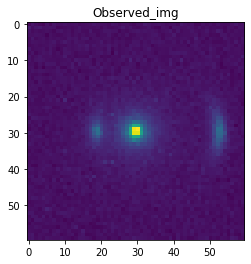

theta_E location in pixels: 46.0


In [318]:
delta_pix = 0.065
num_pix = 60
ctr = num_pix//2
supersample = 1

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
phys_model = PhysicalModel([sis.SIS()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

background_rms, exp_time = 0.2, 100


theta_E = 1.1
center_x, center_y = 0.0, 0.
# # Now I make up other systems

# truth = [[
#     {'theta_E': theta_E, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-6, 'center_x': 0.0, 'center_y': 0.0},
#     {'gamma1': 1e-6, 'gamma2': 1e-6}
# ], [
#     {'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 100.}
# ], [
#     {'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': 0.0, 'center_y': 0.5, 'Ie': 500.}
# ]]


lens_params = [{'theta_E': theta_E, 'center_x': center_x, 'center_y': center_y}]
source_light = [{'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': 0.4, 'center_y': 0.0, 'Ie': 500.}]


truth = [lens_params, 
        [{'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 100.}], 
        source_light]

noiseless_img = lens_sim.simulate(truth)
observed_img = noiseless_img + \
                np.random.normal(0, background_rms, noiseless_img.shape) + \
                np.random.poisson(noiseless_img/exp_time, noiseless_img.shape)
plt.imshow(observed_img)

# observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.imshow(observed_img)
plt.title('Observed_img')
plt.show()

print('theta_E location in pixels:', theta_E//delta_pix + ctr)

(60, 60)
(3600,)


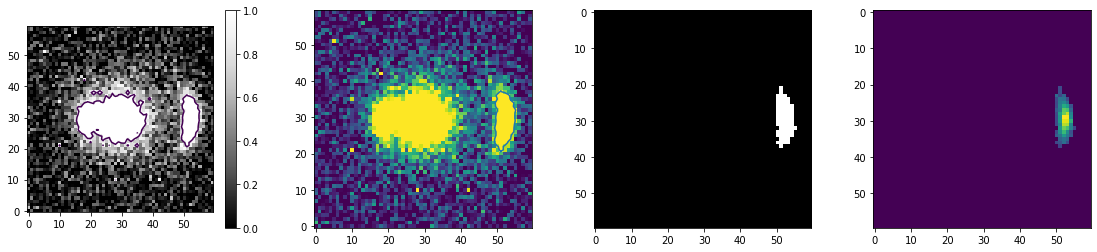

In [319]:
# To get the BIG arc

import matplotlib.patches as patches
from matplotlib.path import Path

n_subfigs = 4
axes = []*n_subfigs
fig_h = 4


fig, axes = plt.subplots(1, n_subfigs, figsize=(fig_h*n_subfigs*1.2, fig_h))
axes[0].set_aspect('equal')
X, Y = np.meshgrid(np.linspace(0, 59, 60), np.linspace(0, 59, 60))
# Z = f(X, Y, pts)
obsim = axes[0].imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower', vmin=0, vmax=1)
plt.colorbar(obsim, ax=axes[0])

con_levels = [1.]

cs = axes[0].contour(X, Y, observed_img, con_levels)

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

verts = cs.collections[0].get_paths()[6].vertices
xc, yc = verts[:, 0], verts[:, 1]
axes[1].plot(xc, yc)

obsim = axes[1].imshow(observed_img, origin='lower', vmin=0, vmax=1)

print(X.shape)
path = Path(verts)
points = np.vstack((X.flatten(), Y.flatten())).T

counterarcmask = path.contains_points(points)
print(counterarcmask.shape)

# bigarcmask = grid.reshape((116,116))
counterarcmask = counterarcmask.reshape((60, 60))

axes[2].imshow(counterarcmask, cmap='gray')
# plt.colorbar()
counterarcmask.shape
# print grid

counterarc = observed_img * counterarcmask
axes[3].imshow(counterarc) #, origin='lower')
# plt.colorbar()

f_xi_ca = f_xi * counterarcmask
f_yi_ca = f_yi * counterarcmask

alfx: [15.115746 15.465957 15.6625   15.793225 15.905197 15.991613 16.090918
 16.175474 16.248007 16.282318 16.352287 16.41155  16.462156 16.526653
 16.570808 16.60804  16.63971  16.666866 16.7173   16.740572 16.760126
 16.776707 16.790894 16.848127 16.856691 16.863867 16.869944 16.875132
 16.914698 16.915663 16.916468 16.91715  16.91773  16.914698 16.915663
 16.916468 16.91715  16.91773  16.848127 16.85669  16.863867 16.869944
 16.875132 16.740572 16.760126 16.776707 16.790894 16.803116 16.526653
 16.570808 16.60804  16.63971  16.666866 16.282318 16.352287 16.41155
 16.462156 16.505693 16.090918 16.175474 16.248007 15.6625   15.793225
 15.905197 16.001736 15.465957]
alfy: [15.115746 15.465957 15.6625   15.793225 15.905197 15.991613 16.090918
 16.175474 16.248007 16.282318 16.352287 16.41155  16.462156 16.526653
 16.570808 16.60804  16.63971  16.666866 16.7173   16.740572 16.760126
 16.776707 16.790894 16.848127 16.856691 16.863867 16.869944 16.875132
 16.914698 16.915663 16.916468 16.

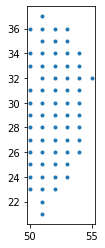

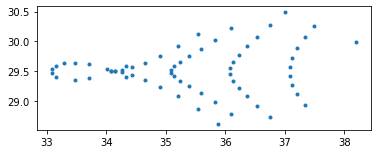

In [320]:
'''

Now delens:

1. get the coord's
2. Assign pixel values -- I have done this where??  On my slides?

Something like this?  From desi-model-xh-dev-GD_wf.ipynb

arcxy = np.where(counterarcmask > 0)

# f_xi, f_yi
alfx = 2*f_xi.sum(axis=2)
alfy = 2*f_yi.sum(axis=2)

print(alfx.shape)

# print('alfx:', alfx[arcxy])
# print('alfy:', alfy[arcxy])
# # print('image flux:', img[goodidx])
# # print('image x:', goodxy[0])
# # print('image y:', goodxy[1])

srcx = arcxy[0] - alfx[arcxy]
srcy = arcxy[1] - alfy[arcxy]

# print('source x:', srcx)
# print('source y:', srcy)

plt.plot(arcxy[0], arcxy[1], '.')
plt.figure()
plt.plot(srcx, srcy, '.')

print(alfx.max(), alfy.max())


kind = 'cubic'
g = interpolate.interp2d(srcx, srcy, obs_super[arcxy]) #, kind=kind)
xsrc = np.linspace(0, 115, 116)
ysrc = np.linspace(0, 115, 116)

src = g(xsrc, ysrc)
plt.imshow(src)
plt.colorbar()
'''

# delensed_src_xx = cour

alfx_pix = np.squeeze(f_xi) / delta_pix
alfy_pix = np.squeeze(f_yi) / delta_pix

arcxy = np.where(counterarcmask > 0)

print('alfx:', alfx_pix[arcxy])
print('alfy:', alfx_pix[arcxy])

# # print('image flux:', img[goodidx])
# # print('image x:', goodxy[0])
# # print('image y:', goodxy[1])

srcx = arcxy[0] - alfy_pix[arcxy]
srcy = arcxy[1] - alfx_pix[arcxy]

# print('source x:', srcx)
# print('source y:', srcy)

plt.plot(arcxy[1], arcxy[0], '.')
ax = plt.gca()
ax.set_aspect('equal')

plt.figure()
plt.plot(srcy, srcx, '.')
ax = plt.gca()
ax.set_aspect('equal')


print(alfx_pix.max(), alfy_pix.max())

In [321]:
srcx = np.array(srcx)
srcy = np.array(srcy)
srcpix = np.array(observed_img[arcxy])
type(srcx), type(srcy), type(srcpix)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [322]:
srcx.shape, srcy.shape, srcpix.shape

((66,), (66,), (66,))

In [323]:
srcpix.max(), srcpix.min(), srcpix.mean()
print(srcpix, srcpix.dtype)

[1.1896826 1.2424996 1.8437297 1.114601  1.6688573 1.1848135 2.0096016
 1.929547  1.1923501 1.1251612 2.1508186 2.3873723 1.8155665 1.1426733
 2.268276  3.2004337 2.8747587 1.3561916 1.4934804 2.12974   3.8818755
 3.6994555 1.7804123 1.2164567 2.912554  4.037426  4.6773186 2.3343098
 1.1678796 2.7278826 5.197431  5.150278  2.52803   1.1706065 2.8280888
 4.966333  4.9428806 3.3771574 1.1942604 2.356642  4.610365  4.546384
 2.3603194 2.7941759 4.0280423 3.6566315 2.3323464 1.0979822 1.207602
 2.5568306 3.529627  2.448588  1.3391058 1.5278149 1.9596317 2.8155
 2.1091406 1.4672967 1.664682  1.9459785 1.7189866 1.1159846 1.3648881
 1.9238111 1.1954179 1.0757303] float32


In [324]:
np.int64(srcpix*100)

array([118, 124, 184, 111, 166, 118, 200, 192, 119, 112, 215, 238, 181,
       114, 226, 320, 287, 135, 149, 212, 388, 369, 178, 121, 291, 403,
       467, 233, 116, 272, 519, 515, 252, 117, 282, 496, 494, 337, 119,
       235, 461, 454, 236, 279, 402, 365, 233, 109, 120, 255, 352, 244,
       133, 152, 195, 281, 210, 146, 166, 194, 171, 111, 136, 192, 119,
       107])

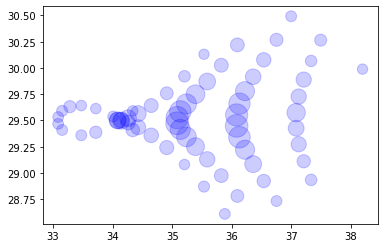

In [325]:
plt.scatter(srcy, srcx, c='b', s=np.int64(srcpix*100), alpha=0.2)

(28.0, 31.0)

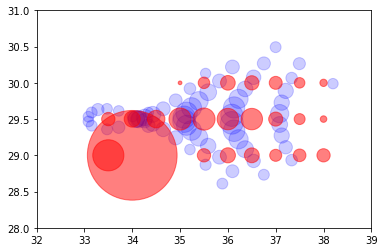

In [331]:
from scipy import interpolate

# kind = 'cubic'
# xx, yy = np.meshgrid(srcx, srcy)

g = interpolate.interp2d(srcx, srcy, srcpix, fill_value=0.0) #, kind=kind)


# xsrc = np.arange(0, 60, 0.5)
# ysrc = np.arange(0, 60, 0.5)

xsrc = np.linspace(0, 59, 119)
ysrc = np.linspace(0, 59, 119)



xxsrc, yysrc = np.meshgrid(xsrc, ysrc)

src = g(xsrc, ysrc)

plt.scatter(srcy, srcx, c='b', s=np.int64(srcpix*100), alpha=0.2)
plt.scatter(yysrc.flatten(), xxsrc.flatten(), s=np.int64(src.flatten()*100), c='r', alpha=0.5)
# plt.xlim(32, 39)
# plt.ylim(28, 31)
plt.xlim(32, 39)
plt.ylim(28, 31)

# plt.imshow(src)
# plt.colorbar()

In [332]:
xsrc

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. ])

In [283]:
idx = src > 0
idx.sum()

7

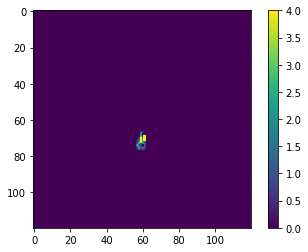

In [289]:
plt.imshow(src, vmin=0, vmax=4) #, cmap='gray')
plt.colorbar()

In [180]:
srcx.shape, arcxy[0].shape, observed_img[arcxy].shape

((78,), (78,), (78,))

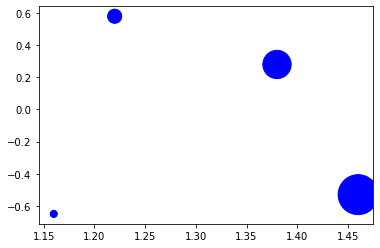

In [233]:
u = np.array([1.22, 1.38, 1.46, 1.16])
v = np.array([0.58, 0.28, -0.53, -0.65])
uvpix = np.array([200, 800, 1600, 50])
plt.scatter(u, v, s=uvpix, c='b')



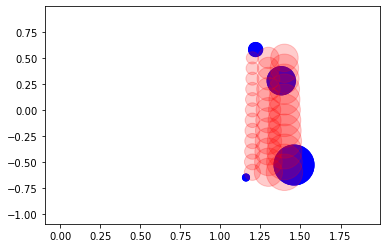

In [247]:
h = interpolate.interp2d(u, v, uvpix, fill_value=0.0)

# u1 = np.array([1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5])
# v1 = np.array([-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])

u1 = np.arange(0, 2, 0.1)
v1 = np.arange(-1, 1, 0.1)



uu, vv = np.meshgrid(u1, v1)

plt.scatter(u, v, s=uvpix, c='b')

newpix1 = h(u1, v1)

u1.shape, v1.shape, newpix1.shape
plt.scatter(u, v, s=uvpix, c='b')
plt.scatter(uu.flatten(), vv.flatten(), s=newpix1.flatten(), c='r', alpha=0.2)

In [245]:
u1

array([-4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
       -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01])

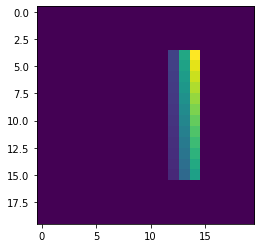

In [248]:
plt.imshow(newpix1)

In [227]:
print(newpix1.shape, uu.shape, vv.shape)

(2, 2) (2, 2) (2, 2)


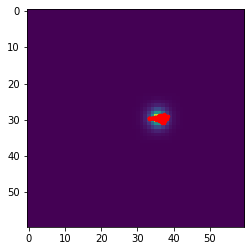

In [175]:
src_img = lens_sim.simulate([[{'theta_E': 1e-8, 'center_x': 1e-10, 'center_y': 1e-10}], [], source_light])
plt.imshow(src_img)
plt.plot(srcy, srcx, 'r.', ms=5)

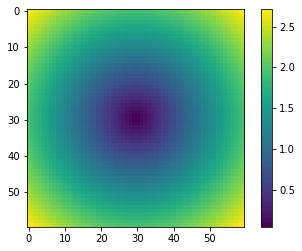

In [119]:
# I really don't understand why img_X and img_Y have structure
# I think the reason is so that they are measured from the center outside, linearly
# then they seem to be right

imgX = lens_sim.img_X
imgY = lens_sim.img_Y

img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

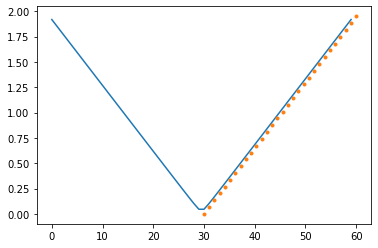

In [120]:
plt.plot(img_t1[30, :])
pix = np.linspace(30, 60, 30)
plt.plot(pix, (pix-30)*delta_pix, '.')

beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}
shapes of beta_x, beta_y: (60, 60, 1) (60, 60, 1)


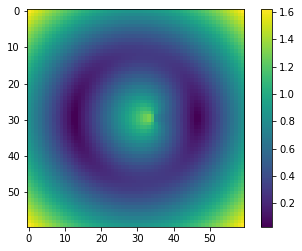

In [138]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

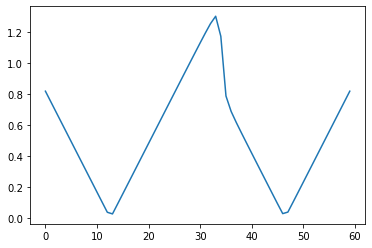

In [122]:
plt.plot(beta_t1[30, :])

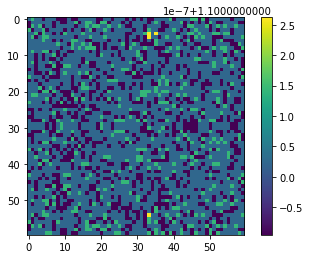

In [139]:
f_xi_t1, f_yi_t1 = f_xi, f_yi
f_t1 = np.sqrt(f_xi_t1**2 + f_yi_t1**2)

plt.imshow(f_t1)
plt.colorbar()

In [124]:
f_t1.mean(), f_t1.max(), f_t1.min()

(1.1000001, 1.1000003, 1.0999999)

In [93]:
imgX.shape, type(imgX)

((60, 60, 1), jaxlib.xla_extension.DeviceArray)

(60, 60) <class 'jaxlib.xla_extension.DeviceArray'>
16.923076923076923 30 30


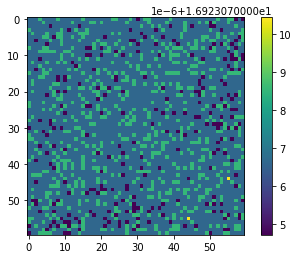

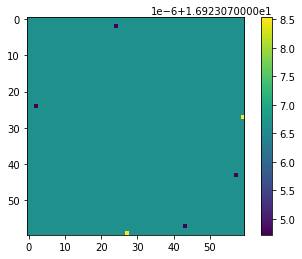

In [108]:
# size = 20
# xctr, yctr = size/2, size/2
# x = np.arange(size)
# y = np.arange(size)
# xx, yy = np.meshgrid(x, y)
# alph = 2.5

xx = np.squeeze(imgX)/delta_pix
yy = np.squeeze(imgY)/delta_pix
xctr, yctr = 30, 30


r_E = theta_E/delta_pix
print(xx.shape, type(xx))

def xderiv(x, y, theta_E, center_x, center_y):
    '''Have to define it outside gigalens, b/c otherwise:
    
    ----> 1 bx, bx, alfx, alfy = sis.SIS.deriv(imgX, imgY, **lens_params)
    TypeError: gigalens.jax.profiles.mass.sis.SIS.deriv() argument after ** must be a mapping, not list
    
    '''
    _params = ["theta_E", "center_x", "center_y"]
    dx, dy = x - center_x, y - center_y
    R = np.sqrt(dx ** 2 + dy ** 2)
    a = np.where(R == 0, 0.0, theta_E / R)
    return a*R, a * dx, a * dy

print(r_E, xctr, yctr)
alf, alfx, alfy = xderiv(xx, yy, r_E, xctr, yctr)

alf_recalc = np.sqrt(alfx**2 + alfy**2)
plt.imshow(alf_recalc)
plt.colorbar()

plt.figure()
plt.imshow(alf)
plt.colorbar()

In [112]:
alf

array([[16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077],
       [16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077],
       [16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077],
       ...,
       [16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077],
       [16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077],
       [16.923077, 16.923077, 16.923077, ..., 16.923077, 16.923077,
        16.923077]], dtype=float32)

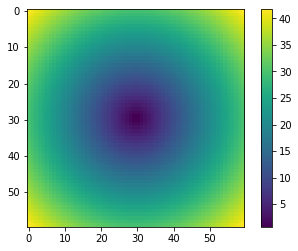

In [107]:
r = np.sqrt(xx**2 + yy**2)
plt.imshow(r)
plt.colorbar()

In [39]:
print(**lens_params[0])

TypeError: 'theta_E' is an invalid keyword argument for print()

In [46]:
u = lens_params[0]
u

{'theta_E': 1.1, 'center_x': 0.0, 'center_y': 0.0}

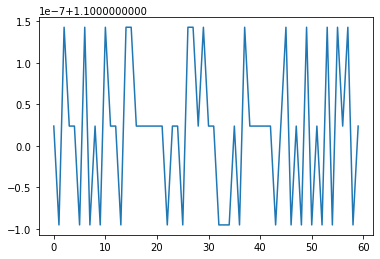

In [25]:
plt.plot(f_t1[30, :])

6
shapes of imgX, imgY: (120, 120, 1) (120, 120, 1)
shapes of f_xi, f_yi: (120, 120, 1) (120, 120, 1)


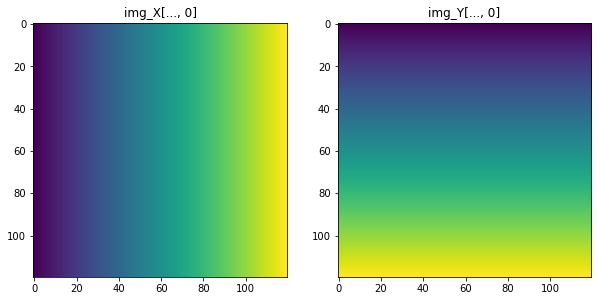

In [42]:
'''
Here I get

shapes of img_X, img_Y: (120, 120, 1) (120, 120, 1)
shapes of f_xi, f_yi: (120, 120, 1) (120, 120, 1)

'''

from objax.functional import average_pool_2d

# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


imgX = lens_sim.img_X
imgY = lens_sim.img_Y

print('shapes of imgX, imgY:', imgX.shape, imgY.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


ax1.imshow(img_X_t1)
ax1.set_title('img_X[..., 0]')
ax2.imshow(img_Y_t1)
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

f_xi_t1, f_yi_t1 = f_xi, f_yi

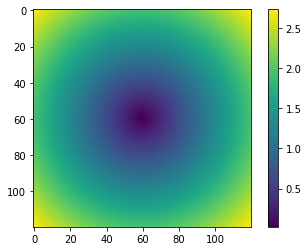

In [40]:
img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

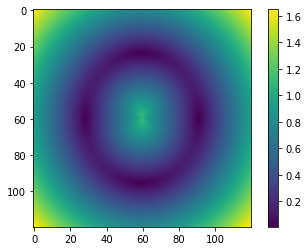

In [41]:
beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [ ]:
    @functools.partial(jit, static_argnums=(0,))
    def _beta(self, lens_params: List[Dict]):
        beta_x, beta_y = self.img_X, self.img_Y
        lens_i = 0
        for lens, p in zip(self.phys_model.lenses, lens_params):
            print('beta for lens #{:d}'.format(lens_i))
            print('lens', lens)
            print('lens params', p)
            lens_i += 1
            f_xi, f_yi = lens.deriv(self.img_X, self.img_Y, **p)
            beta_x, beta_y = beta_x - f_xi, beta_y - f_yi
        return beta_x, beta_y, f_xi, f_yi 


# Next: delens using f_xi_t1, f_yi_t1 and see I recover the forward model source

In [5]:
# ********************************
# on M1, 100 samples, 200 steps: 5 min to run -- so be careful
# ********************************

map_samples = 100

map_steps = 200
transition_steps = 200

seed, lr_start, lr_end, pwr = 0, -1e-2, -1e-2/3, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

DEV version!!!


  0%|          | 0/200 [00:00<?, ?it/s]

beta for lens #0
lens EPL
lens params {'center_x': Traced<ShapedArray(float32[100])>with<JVPTrace(level=2/4)> with
  primal = Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=0/4)>
  tangent = Traced<ShapedArray(float32[100])>with<JaxprTrace(level=1/4)> with
    pval = (ShapedArray(float32[100]), None)
    recipe = LambdaBinding(), 'center_y': Traced<ShapedArray(float32[100])>with<JVPTrace(level=2/4)> with
  primal = Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=0/4)>
  tangent = Traced<ShapedArray(float32[100])>with<JaxprTrace(level=1/4)> with
    pval = (ShapedArray(float32[100]), None)
    recipe = LambdaBinding(), 'e1': Traced<ShapedArray(float32[100])>with<JVPTrace(level=2/4)> with
  primal = Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=0/4)>
  tangent = Traced<ShapedArray(float32[100])>with<JaxprTrace(level=1/4)> with
    pval = (ShapedArray(float32[100]), None)
    recipe = LambdaBinding(), 'e2': Traced<ShapedArray(float32[100])>with


KeyboardInterrupt



In [6]:
import pickle
with open('map_est_2022_09_14-18:12_sim.pickle', 'rb') as f:
    # map_estimate = pickle.load(f)
    map_estimate, chi2_hist, hyper_params = pickle.load(f)
map_estimate.shape

(300, 22)

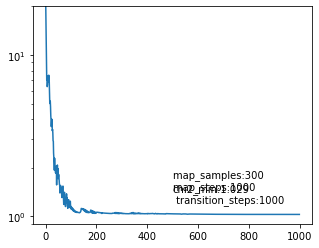

In [12]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

# lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min, hyper_p)
# plt.ylim(2.5, 6)
plt.ylim(0.9, 20)
plt.show()


In [13]:

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_estimate))
# these two lines can take long to run on cpu
# 
lps, chi2 = prob_model.log_prob(lens_sim, map_estimate)
# recon = lens_sim.lstsq_simulate(prob_model.bij.forward(list(map_estimate.T)), 
#                                 obs_data, prob_model.err_map)[np.nanargmax(lps)]

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))

print(map_estimate.shape)
print(np.nanargmax(lps))
print(map_estimate[np.nanargmax(lps)].shape)


beta for lens #0
lens EPL
lens params {'center_x': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'center_y': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'e1': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'e2': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'gamma': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'theta_E': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>}
beta for lens #1
lens SHEAR
lens params {'gamma1': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>, 'gamma2': Traced<ShapedArray(float32[300])>with<DynamicJaxprTrace(level=0/3)>}
(300, 22)
197
(22,)


In [14]:
print(lps.shape)

idx_map_best = np.argmin(chi2)
print('best idx for map:', idx_map_best)

print(chi2.min())

chi2[idx_map_best]

(300,)
best idx for map: 277
1.0261447


DeviceArray(1.0261447, dtype=float32)

beta for lens #0
lens EPL
lens params {'center_x': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'center_y': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'e1': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'e2': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'gamma': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'theta_E': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>}
beta for lens #1
lens SHEAR
lens params {'gamma1': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>, 'gamma2': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/3)>}
(22,)
[1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447
 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447
 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447 1.0261447
 1.0261447]
6
shapes of img_X, img_Y: (120, 120, 22) (120, 120, 22)
beta for lens #0
lens EPL
len

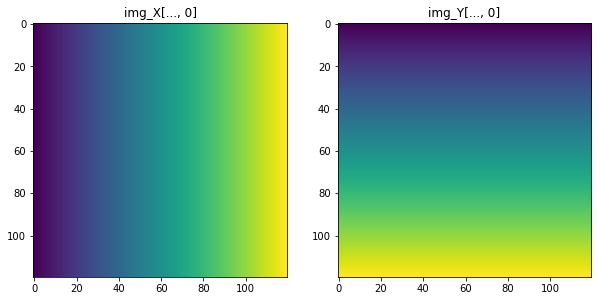

In [15]:
'''
The gist of this cell is that I don't understand the shape:

shapes of img_X, img_Y: (120, 120, 22) (120, 120, 22)
shapes of f_xi, f_yi: (120, 120, 22) (120, 120, 22)

When the last value is the number of parameters.

'''

from objax.functional import average_pool_2d

map_est = map_estimate[idx_map_best]

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_est))
# this line can take long to run on cpu
lps, chi2 = prob_model.log_prob(lens_sim, map_est)

print(chi2.shape)
print(chi2)
phys_params = prob_model.bij.forward(list(map_est.T))

params = phys_params
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)
print(phys_params[0][0])

In [ ]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)
# prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
# model_seq = ModellingSequence(phys_model, prob_model, sim_config)

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

6
shapes of img_X, img_Y: (120, 120, 22) (120, 120, 22)
shapes of f_xi, f_yi: (120, 120, 22) (120, 120, 22)


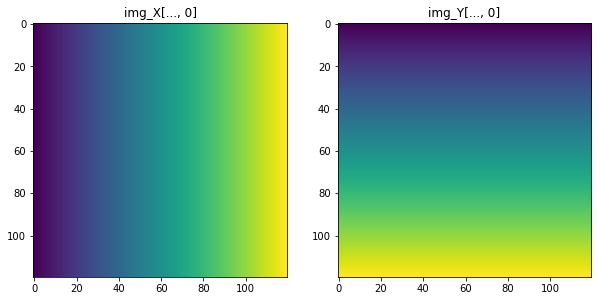

In [17]:
from objax.functional import average_pool_2d

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)


f_xi_t22, f_yi_t22 = f_xi, f_yi

In [38]:
# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
# extract_params(best_params)
# print('Compared with truth: \n')

print('The truth parameters:')
extract_params(truth)

print('The best_params:')
extract_params(best_params)

print('The phys_params:')
extract_params(phys_params)
# chi2_ar = chi2_arr[-100:]
# print('min chi2: {:4.3f}'.format(chi2_arr.min()))

The truth parameters:
Lens mass params (2 sets):
theta_E= 1.100  gamma= 2.000  e1   = 0.200  e2   = 0.000  center_x= 0.000  center_y= 0.000  
gamma1= 0.000  gamma2= 0.000  

Lens light params(1 sets):
R_sersic= 0.800  n_sersic= 4.000  e1   = 0.000  e2   = 0.000  center_x= 0.000  center_y= 0.000  Ie   =100.000  

Source light params(1 sets):
R_sersic= 0.100  n_sersic= 1.000  e1   = 0.000  e2   = 0.000  center_x= 0.000  center_y= 0.000  Ie   =500.000  

The best_params:
Lens mass params (2 sets):
theta_E= 1.096  gamma= 2.303  e1   = 0.248  e2   = 0.006  center_x=-0.002  center_y= 0.000  
gamma1=-0.044  gamma2= 0.004  

Lens light params(1 sets):
R_sersic= 0.748  n_sersic= 3.850  e1   = 0.008  e2   = 0.009  center_x=-0.001  center_y=-0.001  Ie   =111.723  

Source light params(1 sets):
R_sersic= 0.131  n_sersic= 1.054  e1   = 0.019  e2   = 0.010  center_x=-0.001  center_y= 0.000  Ie   =489.895  

The phys_params:
Lens mass params (2 sets):
theta_E= 1.100  gamma= 2.134  e1   = 0.228  e2   

In [ ]:
# compare best-fit parameters with observed image
from astropy import modeling

plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(142)
simulated = lens_sim.simulate(truth)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(143)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)

norm_resid = np.asarray(resid/err_map)

plt.imshow(norm_resid, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

plt.subplot(144)
bin_h, bins, _ = plt.hist(norm_resid.flatten(), bins=100)
x = (bins[:-1] + bins[1:])/2
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, x, bin_h)

plt.plot(x, fitted_model(x))
plt.title(r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(fitted_model.mean.value, fitted_model.stddev.value))

print('Chi-square:', np.mean((resid/err_map)**2))




In [ ]:
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


In [ ]:
from copy import copy
no_lens = copy(truth)
no_lens[0][0]['theta_E'] = 1e-12
no_lens

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

lens params: [{'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-06, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': 1e-06, 'gamma2': 1e-06}]
source light params: [{'R_sersic': 0.01, 'n_sersic': 2.0, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0, 'Ie': 5000.0}]
(100,)
num_pix, delta_pix, scale_extent, ext_arcsec: 61 0.065 2.0 2.015
extent (2.015, -2.015, -2.015, 2.015)


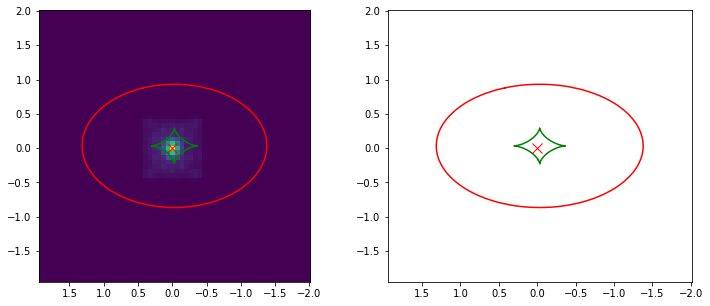

In [8]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# x = lens_sim_t.simulate([truth[0], truth[2], []])
# x = lens_sim_t.simulate(truth)
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lens_plot.lens_model_plot(ax1, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
simulated = lens_sim.simulate([[], truth[2], []])

scale_extent = 2.0
ext_arcsec = ((num_pix+1)*delta_pix)/scale_extent
print('num_pix, delta_pix, scale_extent, ext_arcsec:', num_pix, delta_pix, scale_extent, ext_arcsec)

extent = ext_arcsec, -ext_arcsec, -ext_arcsec, ext_arcsec
print('extent', extent)

ax1.plot(0, 0, 'x', ms=10, color='red')
ax1.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1), extent=extent)

lens_plot.lens_model_plot(ax2, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
ax2.plot(0, 0, 'x', ms=10, color='red')




# ax.imshow(simulated, vmin=0, vmax=1, extent=extent)

# # source_img = np.rot90(np.rot90(x))
# source_img = x

# ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)

In [98]:
simulated.max()

DeviceArray(1.0568318, dtype=float32)

lens params: [{'theta_E': 1e-12, 'gamma': 1.8, 'e1': 0.1, 'e2': 1e-06, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': 1e-06, 'gamma2': 1e-06}]
lens_light_params []
source_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'n_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}]
lens_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<Dyn

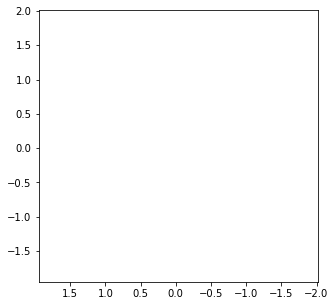

In [37]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([no_lens[0], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

# print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

# scale_extent = 2

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# # source_img = np.rot90(np.rot90(source_img))
# # extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# # ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
# ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
# ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
# ax.grid(axis='both')


# ax2 = ax.twinx().twiny() #here is the trick!
# ax2.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)) #, cmap='GnBu')

# # ax2.tick_params(axis='both', labelcolor='blue')
# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
# ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# # ax2.grid(which='major', axis='both')
# # ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

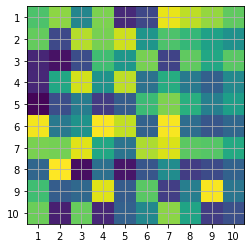

In [38]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

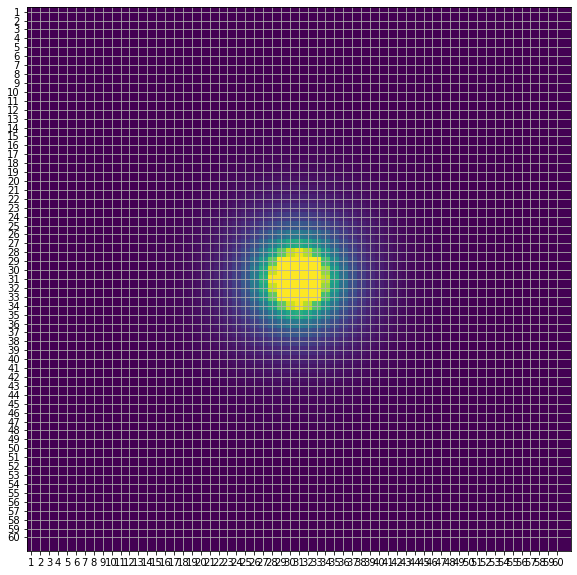

In [39]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

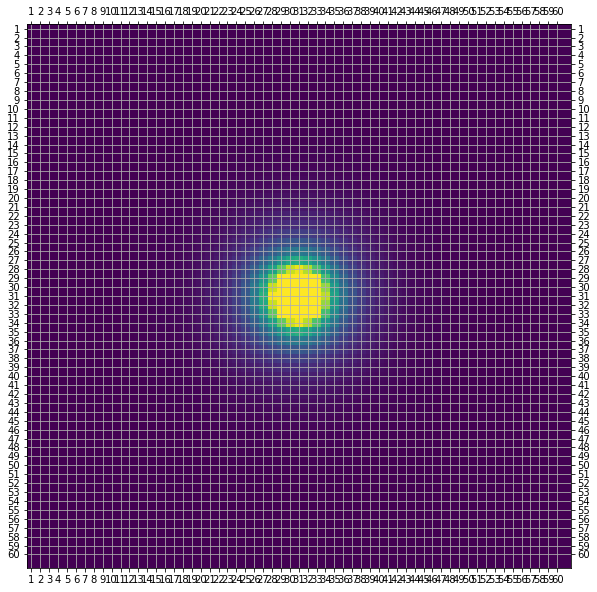

In [40]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(top=True, labeltop=True, right=True, labelright=True)

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

ax.grid(which='major')


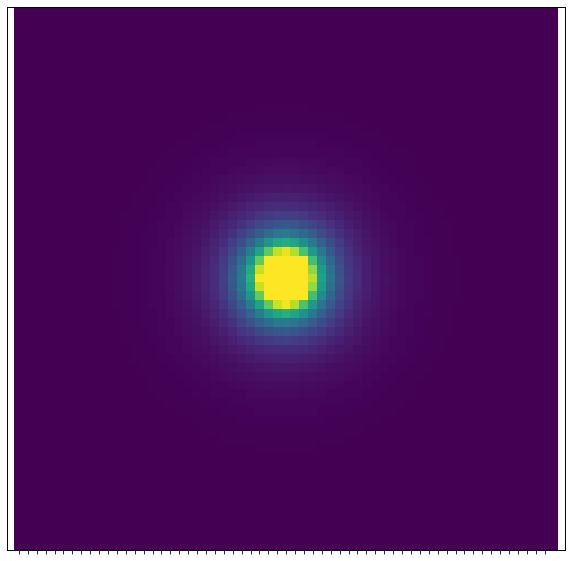

In [41]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)


# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# ax.grid(which='major')

ax2 = ax.twiny() #here is the trick!
ax2.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)

# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=False, labeltop=False, right=False, labelright=False)
# # Major ticks
# # ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# # ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# ax2.grid(which='major', axis='x')


In [42]:
truth[2][0]

{'R_sersic': 0.25,
 'n_sersic': 1.5,
 'e1': 0.0,
 'e2': 0.0,
 'center_x': 0.0,
 'center_y': 0.0,
 'Ie': 150.0}

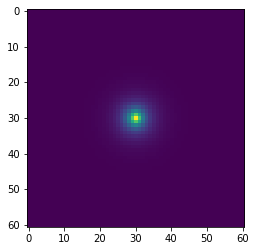

In [43]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

lens_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'n_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}]
source_light_params []


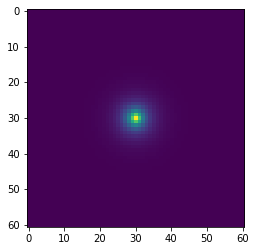

In [44]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

## Next: add cautic and critical curves -- reproduce one of the four archetypes

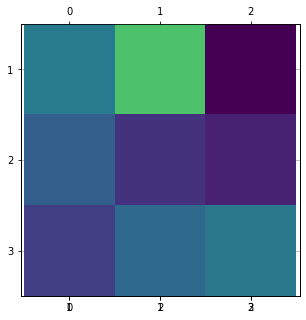

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

nx, ny = 3, 3

np.random.seed(seed=1)
img = np.reshape(np.random.rand(nx*ny), newshape=(nx, ny))

im = ax.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')

# Major ticks
ax.set_xticks(np.arange(0, nx, 1))
ax.set_yticks(np.arange(0, ny, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, nx+1, 1))
ax.set_yticklabels(np.arange(1, ny+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', axis='both')

ax2 = ax.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax2.set_xticks(np.arange(0, nx, 1))
ax2.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax2.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax2.grid(which='major', axis='y')



ax3 = ax2.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax3.set_xticks(np.arange(0, nx, 1))
ax3.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax3.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax3.grid(which='major', axis='y')
plt.show()

